In this notebook, we provide the code to reproduce our experiments on the MNIST, CIFAR10 and CLEVR datasets. This includes the implementation of our models (**GMM**, **VAE-PC-GMM**, **VAE-BP-GMM**, **VAE-GMM**, **VAE-GMM\***) and of the benchmark models (**MCHN**, **MemN2N**, **NTM**), a training procedure for the **MemN2N**, **NTM** and **VAE-GMM\*** models, as well the code to generate the different memory retrieval scenarios presented in the article.

In [ ]:
! pip install -r requirements.txt
! download_monet_model.sh

If you wish to use the CLEVR dataset, you can download it with this cell. Note that this can take a long time.

In [ ]:
! download_clevr.sh

In [1]:
import torch
import os
import numpy as np
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

from utils import *
from models import *
from datasets import *
from options import dataset_options, vae_options, model_options

## 1. Configuration

In [2]:
# Choice of dataset: 'CLEVR' or 'CIFAR10'
dataset_name = 'CLEVR'

# Whether to use a representation component: True or False
representation = True

# Choice of model 'MCHN', 'MemN2N', 'NTM', 'GMM', 'BP-GMM', 'MemN2N_star', 'NTM_star', 'GMM_star'
# Note: the BP-GMM model needs to have chosen representation = True
model_name = 'GMM'

# Experiment choice 'clean', 'noise', 'mask', 'color', 'shift'
# Shift is only available for the CLEVR dataset
exp_name = 'color'

# Experiment parameters: noise standard deviation or mask size
exp_param = None

In [3]:
dataset = dataset_options[dataset_name]
vae = vae_options[dataset_name]
model = model_options[model_name]

## 2. Train or load the representation network

In [4]:
if representation:
    
    # Instantiate VAE net
    vae_net = vae.vae_class(**vae.init_p).cuda()
    
    # Train only if weights cannot be loaded   
    if vae.training and vae_net.training:
        
        # Hyperparameters
        beta = vae.training_hp['beta']
        iterations = vae.training_hp['iterations']
        batch_size = vae.training_hp['batch_size']
        lr = vae.training_hp['lr']
        
        # Training set dataloader
        trainloader = torch.utils.data.DataLoader(dataset(isTrain=True), batch_size=batch_size)
        
        # Training
        optimizer = torch.optim.Adam(vae_net.parameters(), lr=lr)
        
        losses = []
        for i in tqdm(range(iterations)):
            
            iteration_loss = 0
            
            for x in trainloader:
            
                # Use the clean version of the input, this will simply crop the correct image for the CLEVR dataset
                x = exp_transform(x, batch_size, 'clean')
                x = x.cuda()
                
                optimizer.zero_grad()
                
                # Encoding
                mu, logvar = vae_net.encode(x)
                
                # Reparameterization trick
                z = mu + torch.exp(0.5*logvar) * torch.randn_like(mu, device=mu.get_device())
                
                # Decoding
                x_pred = vae_net.decode(z)
                
                # Loss
                rec_loss = nn.MSELoss(reduction='sum')(x_pred, x)
                kl_loss = torch.mean(
                    torch.sum(
                        0.5*(mu**2 + torch.exp(logvar) - 1 - logvar),
                        axis=1
                    ),
                    axis=0
                )
                loss = rec_loss + beta * kl_loss
                iteration_loss += loss.item()
                
                # Backprop
                loss.backward()
                optimizer.step()
                
            losses.append(iteration_loss/(len(trainloader)*batch_size))
            
        plt.plot(losses)
        plt.xlabel('Training iteration')
        plt.ylabel('Training loss')
        plt.show()
        
        torch.save(vae_net.state_dict(), 'saved_models/' + dataset_name + '_ae.pth')
    
    else:
        print("Using pretrained model")
        
    vae_net = vae_net.eval()

Using pretrained model


## 3. Train the model (for -* models)

In [5]:
# Number of patterns inside the memory
N = 100

# Instantiate model
if model.requires_representation:
    if representation:
        model.init_p['vae'] = vae_net
    else:
        raise Error("Model " + model_name + " should be used with representation set to True.")
        
if representation:
    net = model.model_class(vae_net.code_dim, **model.init_p).cuda()
else:
    net = model.model_class(dataset(isTrain=False).item_size(), **model.init_p).cuda()

In [6]:
# For models that require training on the memory retrieval task
if model.training>0:

    if model.training==2:
        filename = os.path.join('saved_models',  model_name + '_' + dataset_name + '_' + str(representation) + '_' + exp_name + '.pth')
    else:
        filename = os.path.join('saved_models', model_name + '_' + dataset_name + '_' + str(representation) + '.pth')

    try:
        net.load_state_dict(torch.load(filename))
        print("Using trained associative memory model.")
        
    except FileNotFoundError:
        
        # Hyperparameters
        iterations = model.training_hp['iterations']
        batch_size = model.training_hp['batch_size']
        if type(model.training_hp['lr']) is dict:
            hp_tag = dataset_name + '_' + str(representation)
            lr = model.training_hp['lr'][hp_tag]
        else:
            lr = model.training_hp['lr']

        # Training set dataloader
        trainloader = torch.utils.data.DataLoader(dataset(isTrain=True), batch_size=N)

        # Training
        optimizer = torch.optim.Adam(net.parameters(), lr=lr)

        losses = []
        for i in tqdm(range(iterations)):

            iteration_loss = 0

            for x in trainloader:

                x = x.cuda()

                with torch.no_grad():

                    # Write patterns in the memory
                    xc = exp_transform(x, N, 'clean')
                    if representation:
                        M = vae_net.encode(xc)[0].reshape(N, -1)
                        net.set_mem(M.unsqueeze(0).repeat(batch_size, 1, 1))
                    else:
                        M = xc.reshape(N, -1)
                        net.set_mem(M.unsqueeze(0).repeat(batch_size, 1, 1))

                    # Apply the transformation on the input patterns
                    if model.training==2:
                        xt = exp_transform(x[:batch_size], batch_size, exp_name, exp_param)
                    else:
                        xt = exp_transform(x[:batch_size], batch_size, 'clean')

                    # Compute the initial estimate provided by the encoder
                    if representation:
                        z = vae_net.encode(xt)[0].reshape(batch_size, -1)
                    else:
                        z = xt.reshape(batch_size, -1)

                # Forward pass through the AM network (only the BP-GMM model actually uses xt)
                optimizer.zero_grad()
                z = net(xt, z, **model.training_p)
                loss = nn.MSELoss()(z, M[:batch_size])
                loss.backward()
                optimizer.step()
                
                iteration_loss += loss.detach().item()

            losses.append(iteration_loss/(len(trainloader)*batch_size))

        plt.plot(losses)
        plt.xlabel('Training iteration')
        plt.ylabel('Training loss')
        plt.show()

        torch.save(net.state_dict(), filename)

## 4. Perform retrieval experiments with the auto-associative memory model

In [8]:
# Instantiate data loader
testset = dataset(isTrain=False)
item_shape = testset.item_shape()
testloader = torch.utils.data.DataLoader(testset, batch_size=N)

# Number of patterns to retrieve in the memory, this can go up to N.
# Reducing this number reduces the computer memory usage.
batch_size = 10

percs = []
for x in tqdm(testloader):
    
    x = x.cuda()
    
    with torch.no_grad():
        
        # Write patterns in the memory
        xc = exp_transform(x, N, 'clean')
        if representation:
            M = vae_net.encode(xc)[0].reshape(N, -1)
            net.set_mem(M.unsqueeze(0).repeat(batch_size, 1, 1))
        else:
            M = xc.reshape(N, -1)
            net.set_mem(M.unsqueeze(0).repeat(batch_size, 1, 1))

        # Apply the transformation on the input patterns
        xt = exp_transform(x[:batch_size], batch_size, exp_name, exp_param)

        # Compute the initial estimate provided by the encoder
        if representation:
            z = vae_net.encode(xt)[0].reshape(batch_size, -1)
        else:
            z = xt.reshape(batch_size, -1)
    
    # Forward pass through the AM network (only the BP-GMM model actually uses xt)
    z = net(xt, z, **model.eval_p)

    # Compute the distance between the inferred representation and the memory pattern
    dists = torch.sqrt(torch.sum((M[:batch_size] - z)**2, axis=1)).cpu()
    
    # Percentage of properly retrieved patterns, the threshold value is arbitrary, but we found
    # that it provides a good discrimination between succesful and failed memory retrievals
    thresh = 5 if representation else 2
    percs.append(100*torch.sum(dists < thresh)/dists.shape[0])


  0%|          | 0/18 [00:00<?, ?it/s]

In [9]:
retrieval_rate = torch.mean(torch.Tensor(percs)).item()
print("Retrieval rate : " + str(retrieval_rate))

Retrieval rate : 58.88888931274414


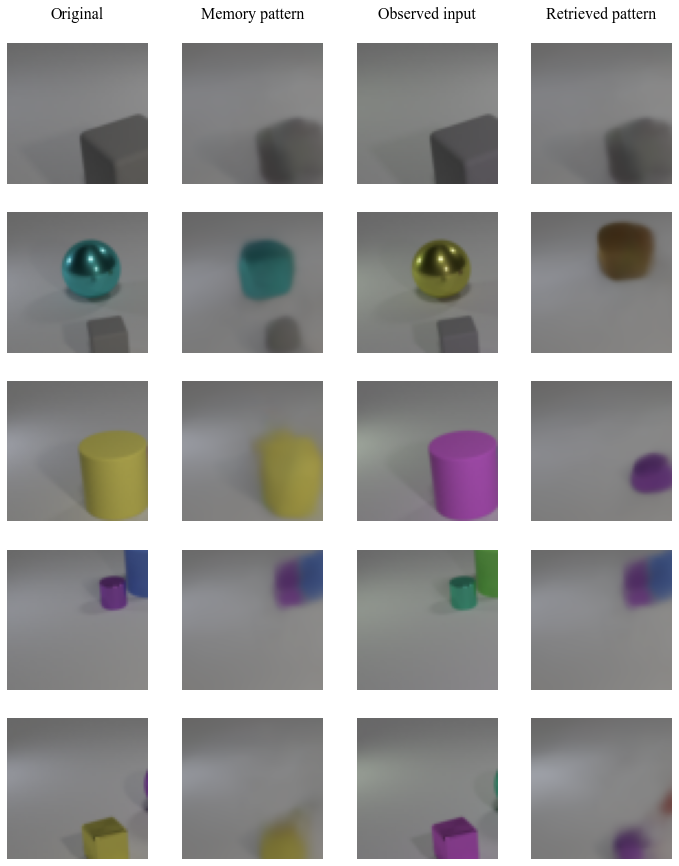

In [10]:
fig = plt.figure(figsize=(4*3, 3*5))
axes = fig.subplots(5, 4)

if representation:
    x_stored = vae_net.decode(M).detach()
    x_pred = vae_net.decode(z).detach()
else:
    x_stored = M.detach()
    x_pred = z.detach()

if dataset_name=='CLEVR':
    xc = renormalize(xc)
    x_stored = renormalize(x_stored)
    xt = renormalize(xt)
    x_pred = renormalize(x_pred)
    
for k in range(5):
    
    axes[k, 0].set_axis_off()
    axes[k, 0].imshow(xc[k].cpu().reshape(*item_shape).transpose(0, 1).transpose(1, 2), vmin=0, vmax=1)
    
    axes[k, 1].set_axis_off()
    axes[k, 1].imshow(x_stored[k].cpu().reshape(*item_shape).transpose(0, 1).transpose(1, 2), vmin=0, vmax=1)
    
    axes[k, 2].set_axis_off()
    axes[k, 2].imshow(xt[k].cpu().reshape(*item_shape).transpose(0, 1).transpose(1, 2), vmin=0, vmax=1)
    
    axes[k, 3].set_axis_off()
    axes[k, 3].imshow(x_pred[k].cpu().reshape(*item_shape).transpose(0, 1).transpose(1, 2), vmin=0, vmax=1)

fn = 'Times New Roman'
axes[0, 0].set_title('Original\n', fontname=fn, fontsize=16)
axes[0, 1].set_title('Memory pattern\n', fontname=fn, fontsize=16)
axes[0, 2].set_title('Observed input\n', fontname=fn, fontsize=16)
axes[0, 3].set_title('Retrieved pattern\n', fontname=fn, fontsize=16)

plt.show()